# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Import Plot Stylesheet

In [3]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd() / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Erzeugnung des Moduls

In [4]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [5]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [6]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [7]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [8]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [9]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [10]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8763
Epoch 1/200, Iteration 2/12, Loss: 0.6395
Epoch 1/200, Iteration 3/12, Loss: 1.7162
Epoch 1/200, Iteration 4/12, Loss: 1.4818
Epoch 1/200, Iteration 5/12, Loss: 0.7982
Epoch 1/200, Iteration 6/12, Loss: 0.3974
Epoch 1/200, Iteration 7/12, Loss: 0.5519
Epoch 1/200, Iteration 8/12, Loss: 0.5234
Epoch 1/200, Iteration 9/12, Loss: 0.5102
Epoch 1/200, Iteration 10/12, Loss: 0.4633
Epoch 1/200, Iteration 11/12, Loss: 0.4603
Epoch 1/200, Iteration 12/12, Loss: 0.4610
Epoch 1/200, Iteration 13/12, Loss: 0.3891
Train Error: 
 Accuracy: 56.5%, Avg loss: 0.455467, MRE: 0.328465, MAE: 0.062122 

Test Error: 
 Accuracy: 61.0%, Avg loss: 0.481301, MRE: 0.330688, MAE: 0.063678 

Epoch 2/200, Iteration 1/12, Loss: 0.4802
Epoch 2/200, Iteration 2/12, Loss: 0.4502
Epoch 2/200, Iteration 3/12, Loss: 0.4796
Epoch 2/200, Iteration 4/12, Loss: 0.3969
Epoch 2/200, Iteration 5/12, Loss: 0.5110
Epoch 2/200, Iteration 6/12, Loss: 0.4299
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 87.0%, Avg loss: 0.105943, MRE: 0.086970, MAE: 0.013553 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.104677, MRE: 0.073395, MAE: 0.013421 

Epoch 13/200, Iteration 1/12, Loss: 0.1064
Epoch 13/200, Iteration 2/12, Loss: 0.1355
Epoch 13/200, Iteration 3/12, Loss: 0.1415
Epoch 13/200, Iteration 4/12, Loss: 0.0820
Epoch 13/200, Iteration 5/12, Loss: 0.1572
Epoch 13/200, Iteration 6/12, Loss: 0.1140
Epoch 13/200, Iteration 7/12, Loss: 0.1563
Epoch 13/200, Iteration 8/12, Loss: 0.1254
Epoch 13/200, Iteration 9/12, Loss: 0.1290
Epoch 13/200, Iteration 10/12, Loss: 0.1219
Epoch 13/200, Iteration 11/12, Loss: 0.1072
Epoch 13/200, Iteration 12/12, Loss: 0.1205
Epoch 13/200, Iteration 13/12, Loss: 0.1113
Train Error: 
 Accuracy: 94.25%, Avg loss: 0.111559, MRE: 0.074913, MAE: 0.015968 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.100829, MRE: 0.054527, MAE: 0.014971 

Epoch 14/200, Iteration 1/12, Loss: 0.1126
Epoch 14/200, Iteration 2/12, Loss: 0.1200
Epoch 14/200, Iterat

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.023292, MRE: 0.018492, MAE: 0.002928 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.025866, MRE: 0.017428, MAE: 0.003120 

Epoch 25/200, Iteration 1/12, Loss: 0.0209
Epoch 25/200, Iteration 2/12, Loss: 0.0199
Epoch 25/200, Iteration 3/12, Loss: 0.0266
Epoch 25/200, Iteration 4/12, Loss: 0.0279
Epoch 25/200, Iteration 5/12, Loss: 0.0276
Epoch 25/200, Iteration 6/12, Loss: 0.0203
Epoch 25/200, Iteration 7/12, Loss: 0.0241
Epoch 25/200, Iteration 8/12, Loss: 0.0226
Epoch 25/200, Iteration 9/12, Loss: 0.0254
Epoch 25/200, Iteration 10/12, Loss: 0.0212
Epoch 25/200, Iteration 11/12, Loss: 0.0216
Epoch 25/200, Iteration 12/12, Loss: 0.0285
Epoch 25/200, Iteration 13/12, Loss: 0.0183
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.021078, MRE: 0.017886, MAE: 0.002668 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.025342, MRE: 0.017697, MAE: 0.003052 

Epoch 26/200, Iteration 1/12, Loss: 0.0230
Epoch 26/200, Iteration 2/12, Loss: 0.0215
Epoch 26/200, Itera

Train Error: 
 Accuracy: 99.38%, Avg loss: 0.020997, MRE: 0.014367, MAE: 0.003122 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.024775, MRE: 0.014464, MAE: 0.003561 

Epoch 37/200, Iteration 1/12, Loss: 0.0214
Epoch 37/200, Iteration 2/12, Loss: 0.0172
Epoch 37/200, Iteration 3/12, Loss: 0.0182
Epoch 37/200, Iteration 4/12, Loss: 0.0241
Epoch 37/200, Iteration 5/12, Loss: 0.0147
Epoch 37/200, Iteration 6/12, Loss: 0.0147
Epoch 37/200, Iteration 7/12, Loss: 0.0190
Epoch 37/200, Iteration 8/12, Loss: 0.0129
Epoch 37/200, Iteration 9/12, Loss: 0.0180
Epoch 37/200, Iteration 10/12, Loss: 0.0224
Epoch 37/200, Iteration 11/12, Loss: 0.0183
Epoch 37/200, Iteration 12/12, Loss: 0.0156
Epoch 37/200, Iteration 13/12, Loss: 0.0138
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.015378, MRE: 0.013690, MAE: 0.002054 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.020452, MRE: 0.013788, MAE: 0.002559 

Epoch 38/200, Iteration 1/12, Loss: 0.0156
Epoch 38/200, Iteration 2/12, Loss: 0.0150
Epoch 38/200, Itera

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.014264, MRE: 0.013101, MAE: 0.001828 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.018233, MRE: 0.012492, MAE: 0.002211 

Epoch 49/200, Iteration 1/12, Loss: 0.0136
Epoch 49/200, Iteration 2/12, Loss: 0.0127
Epoch 49/200, Iteration 3/12, Loss: 0.0150
Epoch 49/200, Iteration 4/12, Loss: 0.0131
Epoch 49/200, Iteration 5/12, Loss: 0.0156
Epoch 49/200, Iteration 6/12, Loss: 0.0127
Epoch 49/200, Iteration 7/12, Loss: 0.0141
Epoch 49/200, Iteration 8/12, Loss: 0.0145
Epoch 49/200, Iteration 9/12, Loss: 0.0122
Epoch 49/200, Iteration 10/12, Loss: 0.0195
Epoch 49/200, Iteration 11/12, Loss: 0.0118
Epoch 49/200, Iteration 12/12, Loss: 0.0152
Epoch 49/200, Iteration 13/12, Loss: 0.0158
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.017865, MRE: 0.013220, MAE: 0.002401 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.021007, MRE: 0.012737, MAE: 0.002672 

Epoch 50/200, Iteration 1/12, Loss: 0.0213
Epoch 50/200, Iteration 2/12, Loss: 0.0126
Epoch 50/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.020428, MRE: 0.015412, MAE: 0.002780 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.021153, MRE: 0.013531, MAE: 0.002755 

Epoch 61/200, Iteration 1/12, Loss: 0.0191
Epoch 61/200, Iteration 2/12, Loss: 0.0163
Epoch 61/200, Iteration 3/12, Loss: 0.0221
Epoch 61/200, Iteration 4/12, Loss: 0.0191
Epoch 61/200, Iteration 5/12, Loss: 0.0217
Epoch 61/200, Iteration 6/12, Loss: 0.0212
Epoch 61/200, Iteration 7/12, Loss: 0.0230
Epoch 61/200, Iteration 8/12, Loss: 0.0181
Epoch 61/200, Iteration 9/12, Loss: 0.0219
Epoch 61/200, Iteration 10/12, Loss: 0.0162
Epoch 61/200, Iteration 11/12, Loss: 0.0187
Epoch 61/200, Iteration 12/12, Loss: 0.0184
Epoch 61/200, Iteration 13/12, Loss: 0.0224
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.018401, MRE: 0.014457, MAE: 0.002345 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.020622, MRE: 0.013060, MAE: 0.002550 

Epoch 62/200, Iteration 1/12, Loss: 0.0169
Epoch 62/200, Iteration 2/12, Loss: 0.0231
Epoch 62/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006381, MRE: 0.006303, MAE: 0.000838 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011313, MRE: 0.007675, MAE: 0.001352 

Epoch 73/200, Iteration 1/12, Loss: 0.0056
Epoch 73/200, Iteration 2/12, Loss: 0.0071
Epoch 73/200, Iteration 3/12, Loss: 0.0049
Epoch 73/200, Iteration 4/12, Loss: 0.0080
Epoch 73/200, Iteration 5/12, Loss: 0.0081
Epoch 73/200, Iteration 6/12, Loss: 0.0058
Epoch 73/200, Iteration 7/12, Loss: 0.0051
Epoch 73/200, Iteration 8/12, Loss: 0.0049
Epoch 73/200, Iteration 9/12, Loss: 0.0078
Epoch 73/200, Iteration 10/12, Loss: 0.0052
Epoch 73/200, Iteration 11/12, Loss: 0.0059
Epoch 73/200, Iteration 12/12, Loss: 0.0058
Epoch 73/200, Iteration 13/12, Loss: 0.0072
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005996, MRE: 0.006028, MAE: 0.000791 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010744, MRE: 0.007148, MAE: 0.001300 

Epoch 74/200, Iteration 1/12, Loss: 0.0056
Epoch 74/200, Iteration 2/12, Loss: 0.0048
Epoch 74/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005640, MRE: 0.005809, MAE: 0.000719 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010682, MRE: 0.007241, MAE: 0.001277 

Epoch 85/200, Iteration 1/12, Loss: 0.0057
Epoch 85/200, Iteration 2/12, Loss: 0.0046
Epoch 85/200, Iteration 3/12, Loss: 0.0049
Epoch 85/200, Iteration 4/12, Loss: 0.0062
Epoch 85/200, Iteration 5/12, Loss: 0.0050
Epoch 85/200, Iteration 6/12, Loss: 0.0070
Epoch 85/200, Iteration 7/12, Loss: 0.0050
Epoch 85/200, Iteration 8/12, Loss: 0.0048
Epoch 85/200, Iteration 9/12, Loss: 0.0043
Epoch 85/200, Iteration 10/12, Loss: 0.0067
Epoch 85/200, Iteration 11/12, Loss: 0.0056
Epoch 85/200, Iteration 12/12, Loss: 0.0063
Epoch 85/200, Iteration 13/12, Loss: 0.0061
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005202, MRE: 0.005592, MAE: 0.000673 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010443, MRE: 0.007109, MAE: 0.001245 

Epoch 86/200, Iteration 1/12, Loss: 0.0053
Epoch 86/200, Iteration 2/12, Loss: 0.0065
Epoch 86/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005564, MRE: 0.005757, MAE: 0.000734 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010537, MRE: 0.006965, MAE: 0.001266 

Epoch 97/200, Iteration 1/12, Loss: 0.0048
Epoch 97/200, Iteration 2/12, Loss: 0.0042
Epoch 97/200, Iteration 3/12, Loss: 0.0065
Epoch 97/200, Iteration 4/12, Loss: 0.0065
Epoch 97/200, Iteration 5/12, Loss: 0.0037
Epoch 97/200, Iteration 6/12, Loss: 0.0047
Epoch 97/200, Iteration 7/12, Loss: 0.0072
Epoch 97/200, Iteration 8/12, Loss: 0.0047
Epoch 97/200, Iteration 9/12, Loss: 0.0046
Epoch 97/200, Iteration 10/12, Loss: 0.0048
Epoch 97/200, Iteration 11/12, Loss: 0.0064
Epoch 97/200, Iteration 12/12, Loss: 0.0060
Epoch 97/200, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005005, MRE: 0.005565, MAE: 0.000652 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010192, MRE: 0.006965, MAE: 0.001215 

Epoch 98/200, Iteration 1/12, Loss: 0.0052
Epoch 98/200, Iteration 2/12, Loss: 0.0048
Epoch 98/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004572, MRE: 0.005275, MAE: 0.000597 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010023, MRE: 0.006736, MAE: 0.001198 

Epoch 109/200, Iteration 1/12, Loss: 0.0041
Epoch 109/200, Iteration 2/12, Loss: 0.0056
Epoch 109/200, Iteration 3/12, Loss: 0.0049
Epoch 109/200, Iteration 4/12, Loss: 0.0050
Epoch 109/200, Iteration 5/12, Loss: 0.0038
Epoch 109/200, Iteration 6/12, Loss: 0.0039
Epoch 109/200, Iteration 7/12, Loss: 0.0062
Epoch 109/200, Iteration 8/12, Loss: 0.0045
Epoch 109/200, Iteration 9/12, Loss: 0.0040
Epoch 109/200, Iteration 10/12, Loss: 0.0039
Epoch 109/200, Iteration 11/12, Loss: 0.0041
Epoch 109/200, Iteration 12/12, Loss: 0.0063
Epoch 109/200, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004538, MRE: 0.005222, MAE: 0.000595 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010046, MRE: 0.006792, MAE: 0.001202 

Epoch 110/200, Iteration 1/12, Loss: 0.0059
Epoch 110/200, Iteration 2/12, Loss: 0.0036
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004495, MRE: 0.005250, MAE: 0.000590 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009955, MRE: 0.006671, MAE: 0.001190 

Epoch 121/200, Iteration 1/12, Loss: 0.0062
Epoch 121/200, Iteration 2/12, Loss: 0.0043
Epoch 121/200, Iteration 3/12, Loss: 0.0038
Epoch 121/200, Iteration 4/12, Loss: 0.0040
Epoch 121/200, Iteration 5/12, Loss: 0.0051
Epoch 121/200, Iteration 6/12, Loss: 0.0036
Epoch 121/200, Iteration 7/12, Loss: 0.0044
Epoch 121/200, Iteration 8/12, Loss: 0.0042
Epoch 121/200, Iteration 9/12, Loss: 0.0047
Epoch 121/200, Iteration 10/12, Loss: 0.0038
Epoch 121/200, Iteration 11/12, Loss: 0.0045
Epoch 121/200, Iteration 12/12, Loss: 0.0061
Epoch 121/200, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004514, MRE: 0.005208, MAE: 0.000591 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010016, MRE: 0.006757, MAE: 0.001200 

Epoch 122/200, Iteration 1/12, Loss: 0.0037
Epoch 122/200, Iteration 2/12, Loss: 0.0034
Epoc

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009919, MRE: 0.006674, MAE: 0.001185 

Epoch 133/200, Iteration 1/12, Loss: 0.0039
Epoch 133/200, Iteration 2/12, Loss: 0.0038
Epoch 133/200, Iteration 3/12, Loss: 0.0055
Epoch 133/200, Iteration 4/12, Loss: 0.0037
Epoch 133/200, Iteration 5/12, Loss: 0.0072
Epoch 133/200, Iteration 6/12, Loss: 0.0059
Epoch 133/200, Iteration 7/12, Loss: 0.0044
Epoch 133/200, Iteration 8/12, Loss: 0.0049
Epoch 133/200, Iteration 9/12, Loss: 0.0036
Epoch 133/200, Iteration 10/12, Loss: 0.0039
Epoch 133/200, Iteration 11/12, Loss: 0.0039
Epoch 133/200, Iteration 12/12, Loss: 0.0040
Epoch 133/200, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004497, MRE: 0.005253, MAE: 0.000590 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009880, MRE: 0.006629, MAE: 0.001182 

Epoch 134/200, Iteration 1/12, Loss: 0.0036
Epoch 134/200, Iteration 2/12, Loss: 0.0036
Epoch 134/200, Iteration 3/12, Loss: 0.0050
Epoch 134/200, Iteration 4/12, Loss: 0.0032


Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004594, MRE: 0.006951, MAE: 0.000612 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009945, MRE: 0.006693, MAE: 0.001193 

Epoch 145/200, Iteration 1/12, Loss: 0.0063
Epoch 145/200, Iteration 2/12, Loss: 0.0041
Epoch 145/200, Iteration 3/12, Loss: 0.0036
Epoch 145/200, Iteration 4/12, Loss: 0.0060
Epoch 145/200, Iteration 5/12, Loss: 0.0061
Epoch 145/200, Iteration 6/12, Loss: 0.0035
Epoch 145/200, Iteration 7/12, Loss: 0.0034
Epoch 145/200, Iteration 8/12, Loss: 0.0035
Epoch 145/200, Iteration 9/12, Loss: 0.0048
Epoch 145/200, Iteration 10/12, Loss: 0.0034
Epoch 145/200, Iteration 11/12, Loss: 0.0045
Epoch 145/200, Iteration 12/12, Loss: 0.0048
Epoch 145/200, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004378, MRE: 0.005163, MAE: 0.000576 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009882, MRE: 0.006644, MAE: 0.001185 

Epoch 146/200, Iteration 1/12, Loss: 0.0060
Epoch 146/200, Iteration 2/12, Loss: 0.0044
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004382, MRE: 0.005180, MAE: 0.000579 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009925, MRE: 0.006692, MAE: 0.001189 

Epoch 157/200, Iteration 1/12, Loss: 0.0060
Epoch 157/200, Iteration 2/12, Loss: 0.0041
Epoch 157/200, Iteration 3/12, Loss: 0.0048
Epoch 157/200, Iteration 4/12, Loss: 0.0073
Epoch 157/200, Iteration 5/12, Loss: 0.0039
Epoch 157/200, Iteration 6/12, Loss: 0.0034
Epoch 157/200, Iteration 7/12, Loss: 0.0046
Epoch 157/200, Iteration 8/12, Loss: 0.0043
Epoch 157/200, Iteration 9/12, Loss: 0.0036
Epoch 157/200, Iteration 10/12, Loss: 0.0037
Epoch 157/200, Iteration 11/12, Loss: 0.0038
Epoch 157/200, Iteration 12/12, Loss: 0.0037
Epoch 157/200, Iteration 13/12, Loss: 0.0042
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004365, MRE: 0.005167, MAE: 0.000573 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009901, MRE: 0.006625, MAE: 0.001188 

Epoch 158/200, Iteration 1/12, Loss: 0.0045
Epoch 158/200, Iteration 2/12, Loss: 0.0059
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004409, MRE: 0.005177, MAE: 0.000575 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009860, MRE: 0.006641, MAE: 0.001178 

Epoch 169/200, Iteration 1/12, Loss: 0.0040
Epoch 169/200, Iteration 2/12, Loss: 0.0056
Epoch 169/200, Iteration 3/12, Loss: 0.0035
Epoch 169/200, Iteration 4/12, Loss: 0.0055
Epoch 169/200, Iteration 5/12, Loss: 0.0040
Epoch 169/200, Iteration 6/12, Loss: 0.0043
Epoch 169/200, Iteration 7/12, Loss: 0.0033
Epoch 169/200, Iteration 8/12, Loss: 0.0039
Epoch 169/200, Iteration 9/12, Loss: 0.0043
Epoch 169/200, Iteration 10/12, Loss: 0.0033
Epoch 169/200, Iteration 11/12, Loss: 0.0070
Epoch 169/200, Iteration 12/12, Loss: 0.0037
Epoch 169/200, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004326, MRE: 0.005145, MAE: 0.000569 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009853, MRE: 0.006636, MAE: 0.001177 

Epoch 170/200, Iteration 1/12, Loss: 0.0039
Epoch 170/200, Iteration 2/12, Loss: 0.0080
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004301, MRE: 0.005089, MAE: 0.000564 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009856, MRE: 0.006635, MAE: 0.001178 

Epoch 181/200, Iteration 1/12, Loss: 0.0031
Epoch 181/200, Iteration 2/12, Loss: 0.0029
Epoch 181/200, Iteration 3/12, Loss: 0.0047
Epoch 181/200, Iteration 4/12, Loss: 0.0040
Epoch 181/200, Iteration 5/12, Loss: 0.0043
Epoch 181/200, Iteration 6/12, Loss: 0.0031
Epoch 181/200, Iteration 7/12, Loss: 0.0059
Epoch 181/200, Iteration 8/12, Loss: 0.0040
Epoch 181/200, Iteration 9/12, Loss: 0.0039
Epoch 181/200, Iteration 10/12, Loss: 0.0059
Epoch 181/200, Iteration 11/12, Loss: 0.0069
Epoch 181/200, Iteration 12/12, Loss: 0.0029
Epoch 181/200, Iteration 13/12, Loss: 0.0050
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004316, MRE: 0.005130, MAE: 0.000567 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009851, MRE: 0.006634, MAE: 0.001177 

Epoch 182/200, Iteration 1/12, Loss: 0.0057
Epoch 182/200, Iteration 2/12, Loss: 0.0043
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004299, MRE: 0.005126, MAE: 0.000564 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009846, MRE: 0.006627, MAE: 0.001177 

Epoch 193/200, Iteration 1/12, Loss: 0.0035
Epoch 193/200, Iteration 2/12, Loss: 0.0037
Epoch 193/200, Iteration 3/12, Loss: 0.0038
Epoch 193/200, Iteration 4/12, Loss: 0.0058
Epoch 193/200, Iteration 5/12, Loss: 0.0034
Epoch 193/200, Iteration 6/12, Loss: 0.0035
Epoch 193/200, Iteration 7/12, Loss: 0.0041
Epoch 193/200, Iteration 8/12, Loss: 0.0055
Epoch 193/200, Iteration 9/12, Loss: 0.0038
Epoch 193/200, Iteration 10/12, Loss: 0.0038
Epoch 193/200, Iteration 11/12, Loss: 0.0034
Epoch 193/200, Iteration 12/12, Loss: 0.0060
Epoch 193/200, Iteration 13/12, Loss: 0.0071
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004300, MRE: 0.005109, MAE: 0.000565 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.009846, MRE: 0.006628, MAE: 0.001177 

Epoch 194/200, Iteration 1/12, Loss: 0.0051
Epoch 194/200, Iteration 2/12, Loss: 0.0037
Epoc

#### Plots loss vs Epoch

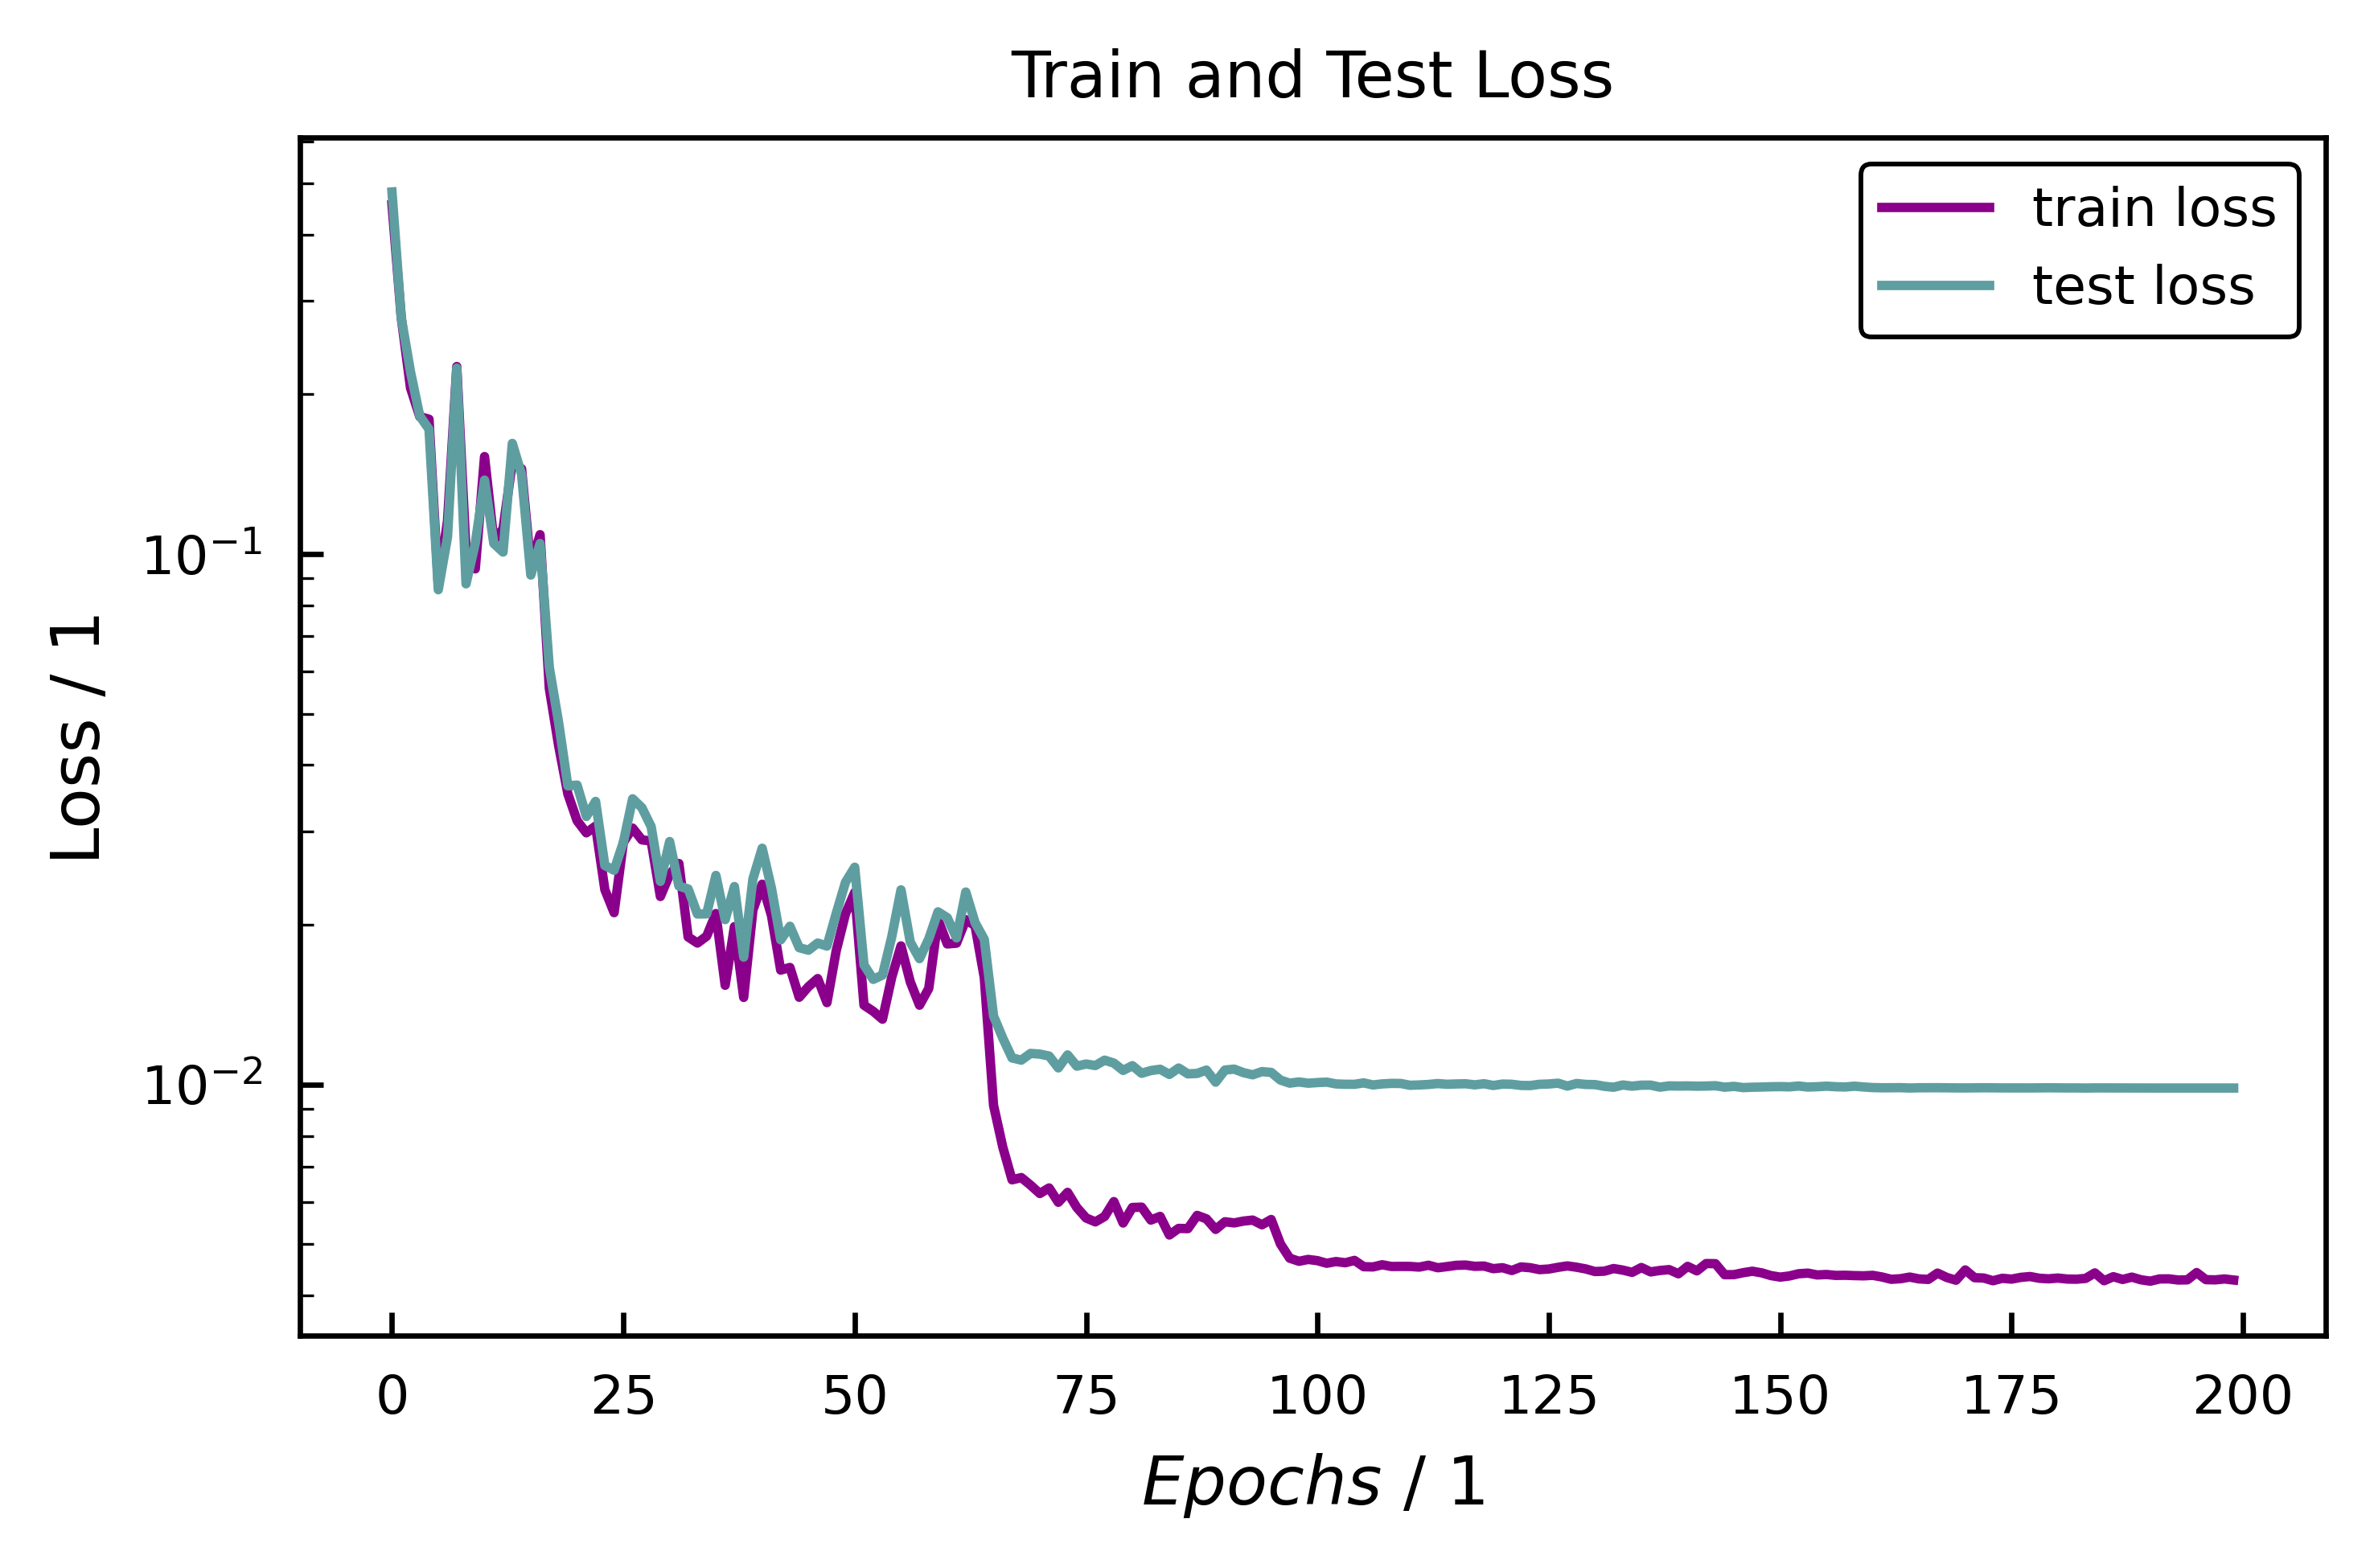

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Exportieren der Lernkurven zur Auswertung

In [12]:
#np.savez('data/models/hyperparams/loss_005_002.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998875844858528 , R^2(NH3) = 0.9998158100416167
Test Dataset: R^2(H2) = 0.9998959525593639 , R^2(NH3) = 0.9996491471081321
Test Dataset: R^2(gemittelt)= 0.999772549833748
Max Error Training: |x_H2 - x_H2,pred| = 0.04613207548951648 , |x_NH3 - x_NH3,pred| = 0.01990929830831273
Max Error Test: |x_H2 - x_H2,pred| = 0.007105771819799878 , |x_NH3 - x_NH3,pred| = 0.017171176953266726


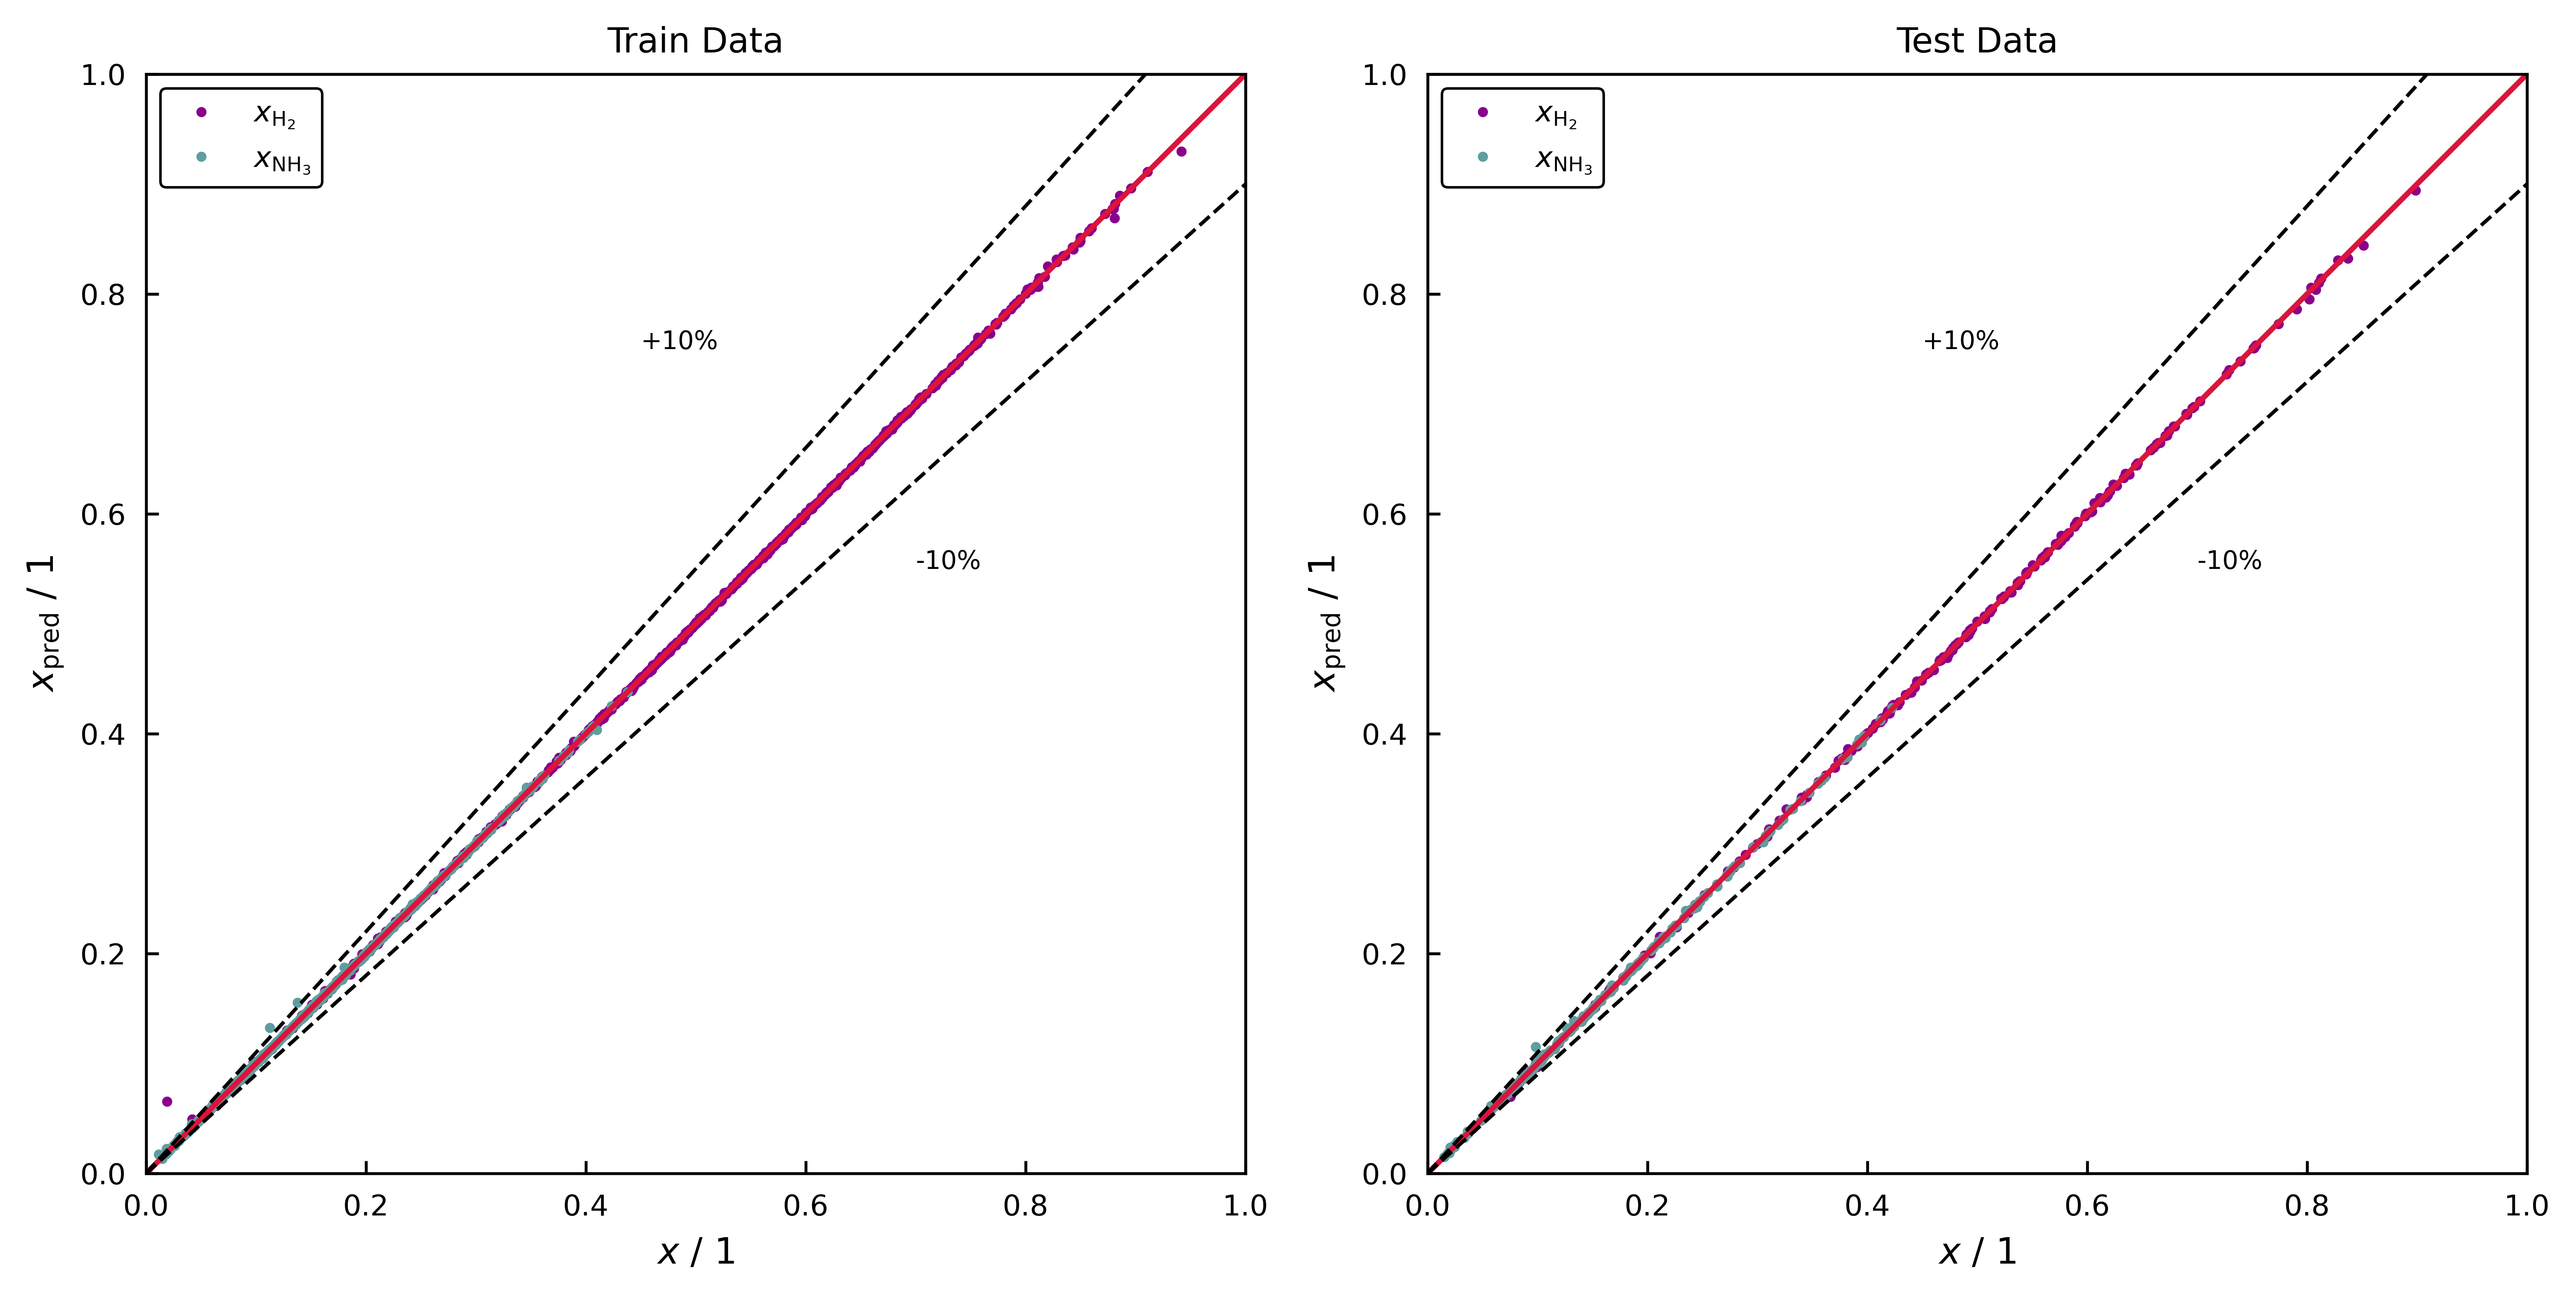

In [13]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Test Dataset: R^2(gemittelt)=', (r2(x_H2_real_test,x_H2_pred_test)+r2(x_NH3_real_test,x_NH3_pred_test))/2)
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize=(10,10))


# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "-",color='crimson',lw=1.5 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line

ax[0].text(0.45, 0.75, '+10%', fontsize=7)
ax[0].text(0.7, 0.55, '-10%', fontsize=7)
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "-",color='crimson',lw=1.5 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line

ax[1].text(0.45, 0.75, '+10%', fontsize=7)
ax[1].text(0.7, 0.55, '-10%', fontsize=7)
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

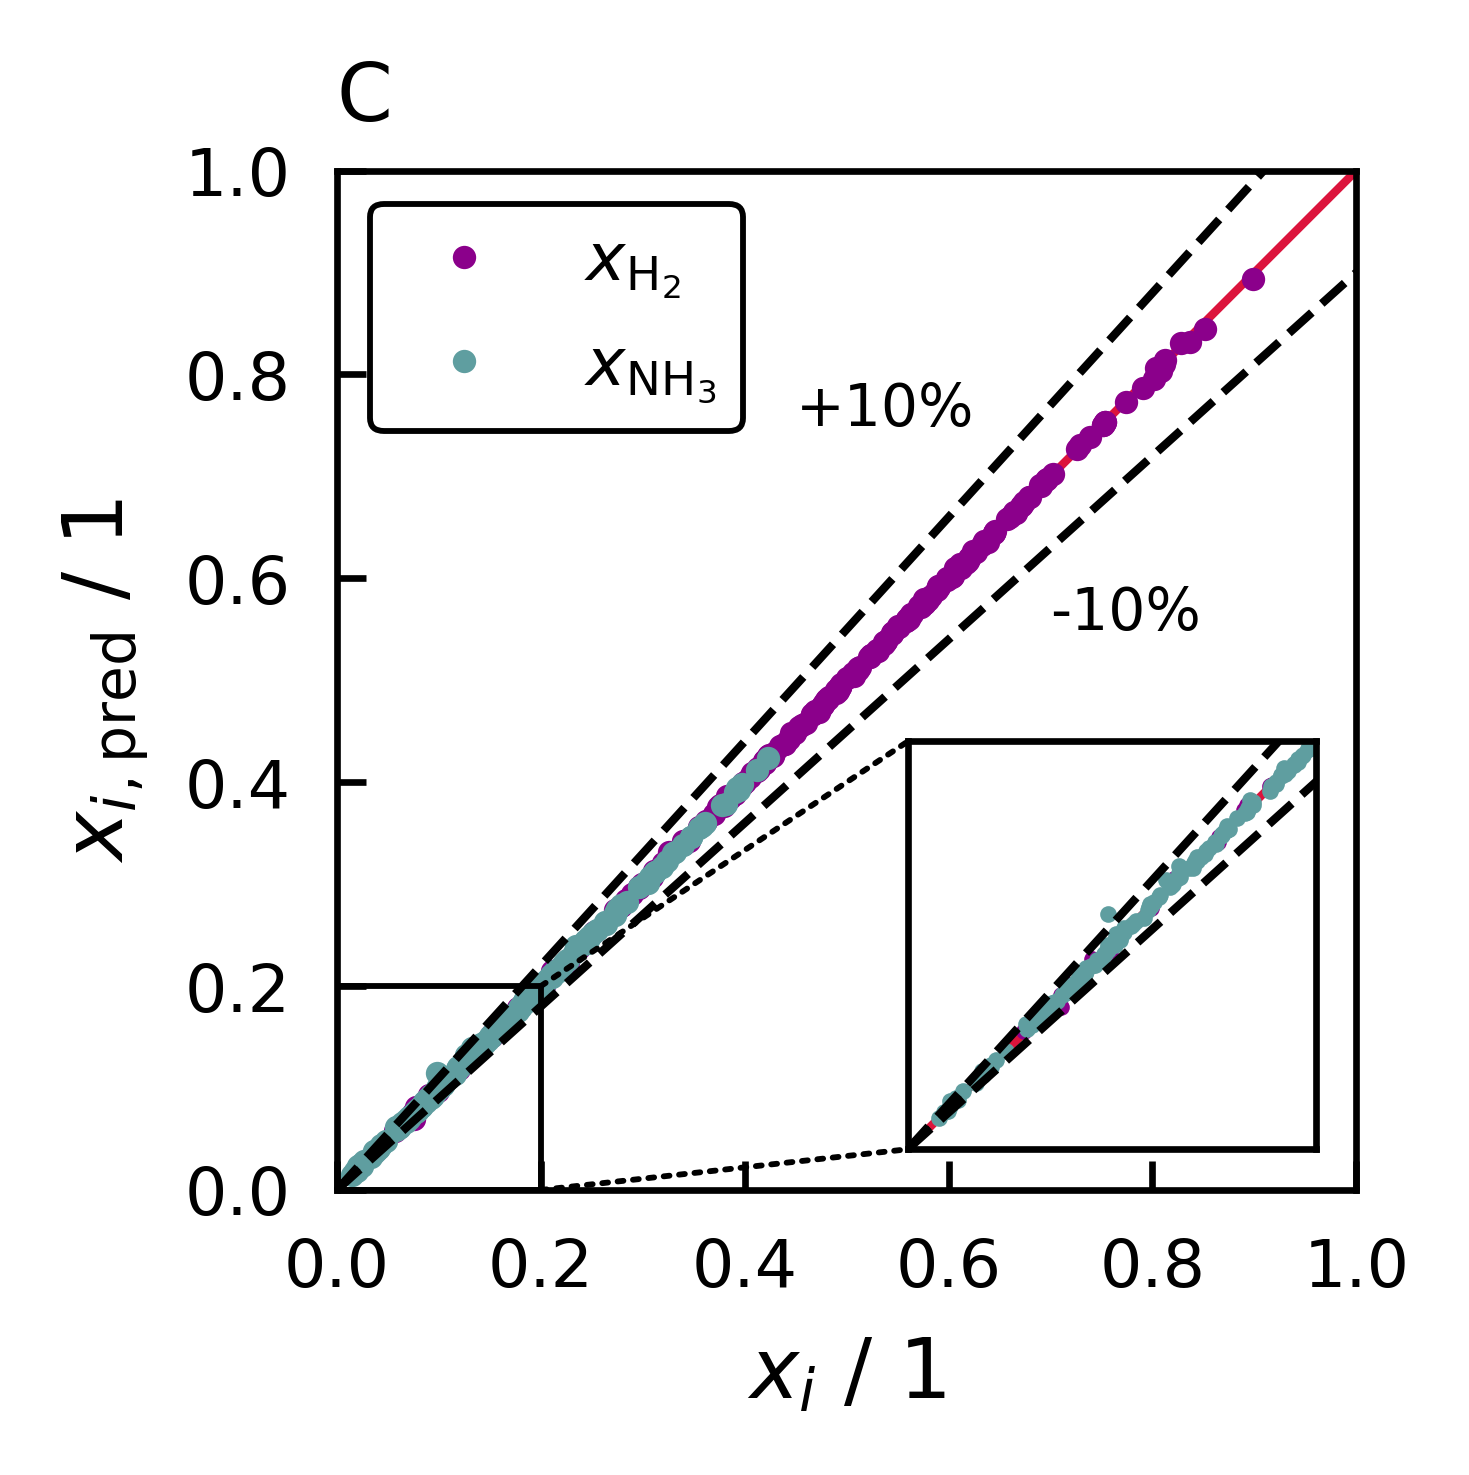

In [14]:
fig,ax = plt.subplots(figsize=(6.5*cm,6.5*cm))

# # Reset the limits
# ax= plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real_test, x_H2_pred_test, '.', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real_test, x_NH3_pred_test, '.', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "-",color='crimson',lw=1 ,transform=ax.transAxes, zorder=1)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line

ax.text(0.45, 0.75, '+10%', fontsize=7)
ax.text(0.7, 0.55, '-10%', fontsize=7)
ax.set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('C',loc='left')
ax.legend()

x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin1 = ax.inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(x_H2_real_test, x_H2_pred_test, '.', markersize = 4)
axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax.indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.0), xyB=(0, 0), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax.add_patch(cp1)
ax.add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [15]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_010_parity_norm.png', bbox_inches = 'tight')

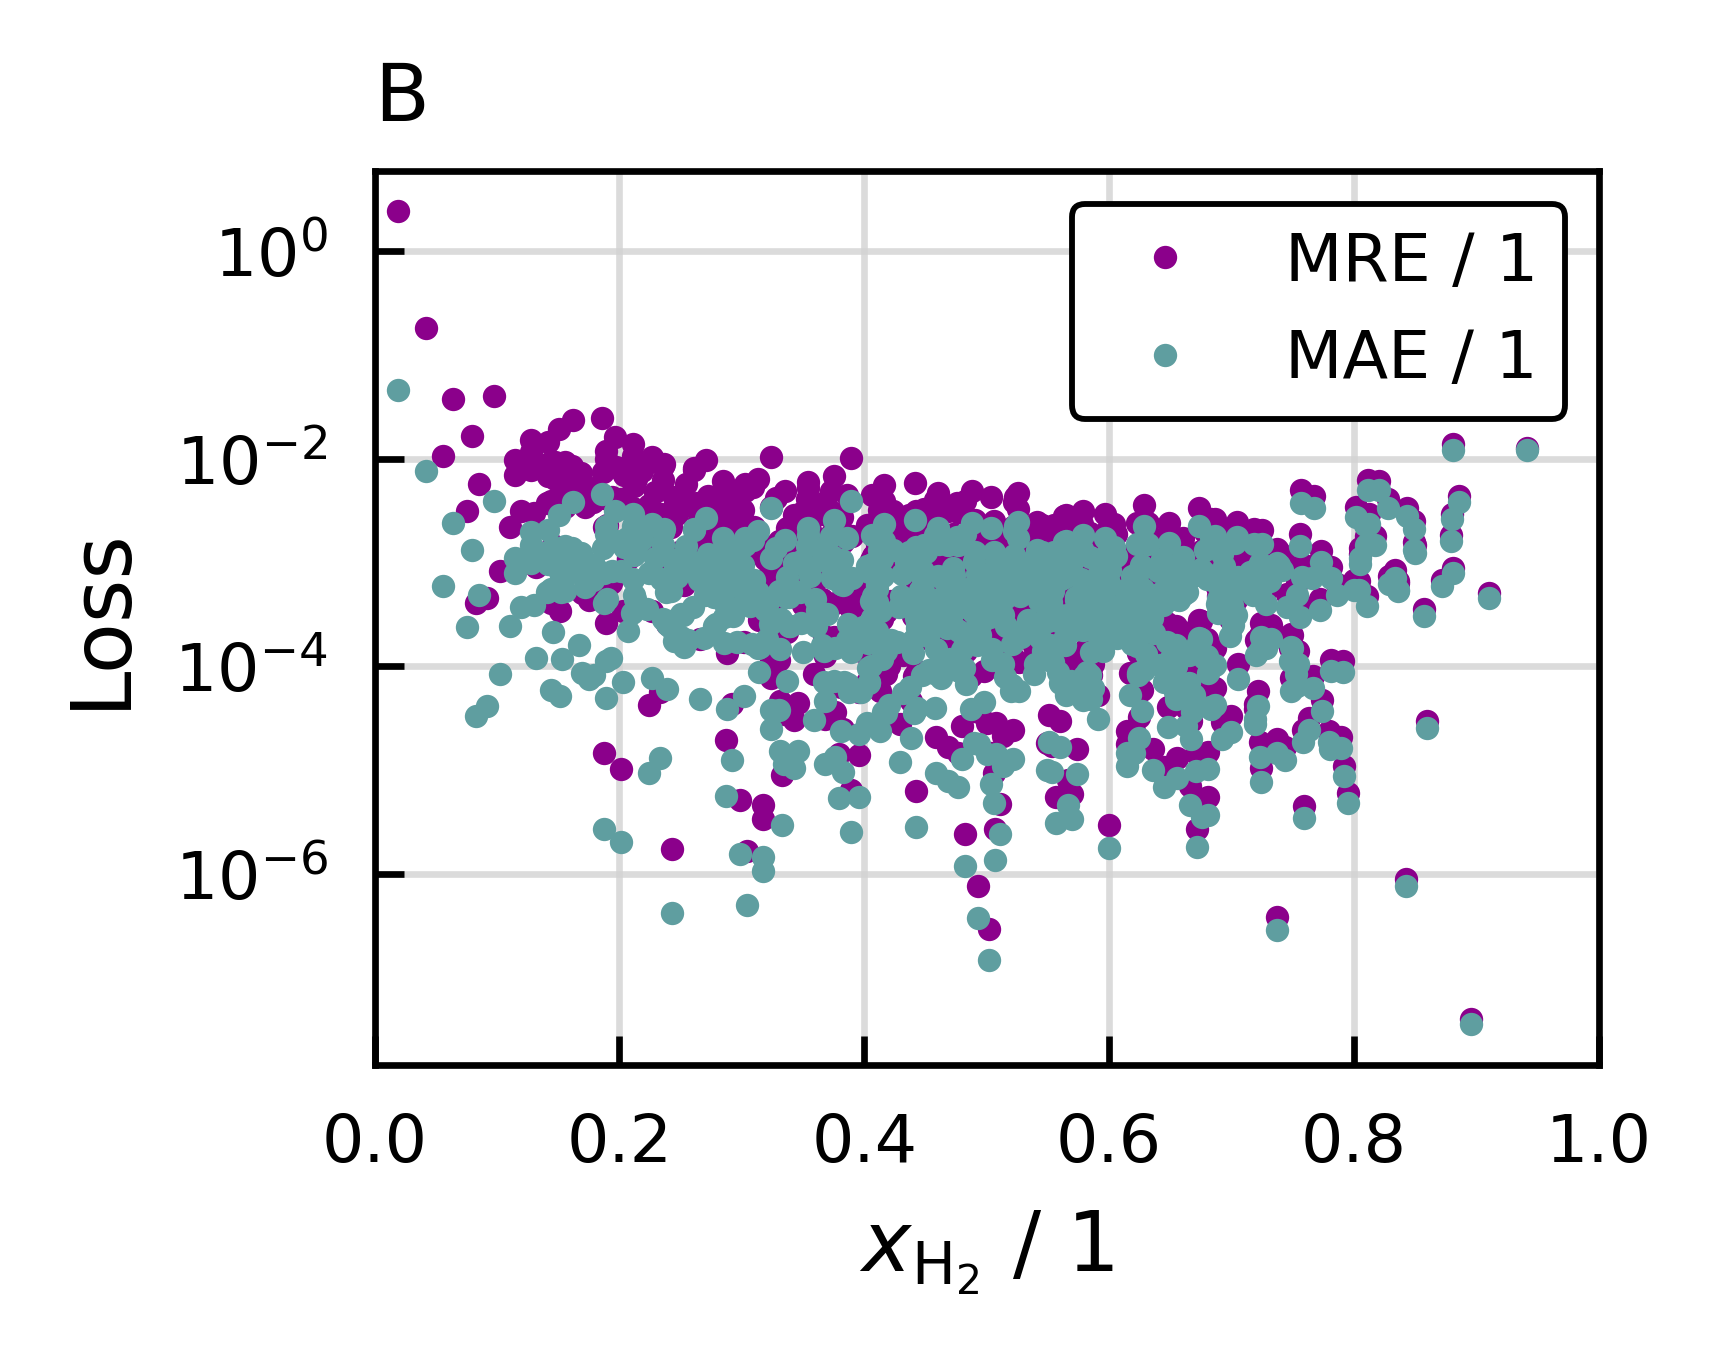

In [16]:
fig,ax = plt.subplots(figsize=(7.5*cm,6*cm))
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE / 1')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE / 1')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Loss')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set(xlim=(0,1))
ax.grid()
ax.set_title('B', loc='left')

plt.legend()
plt.tight_layout()
plt.show()

In [17]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_018_loss_x.png', bbox_inches = 'tight')

#### Plot Fehler vs Epoch

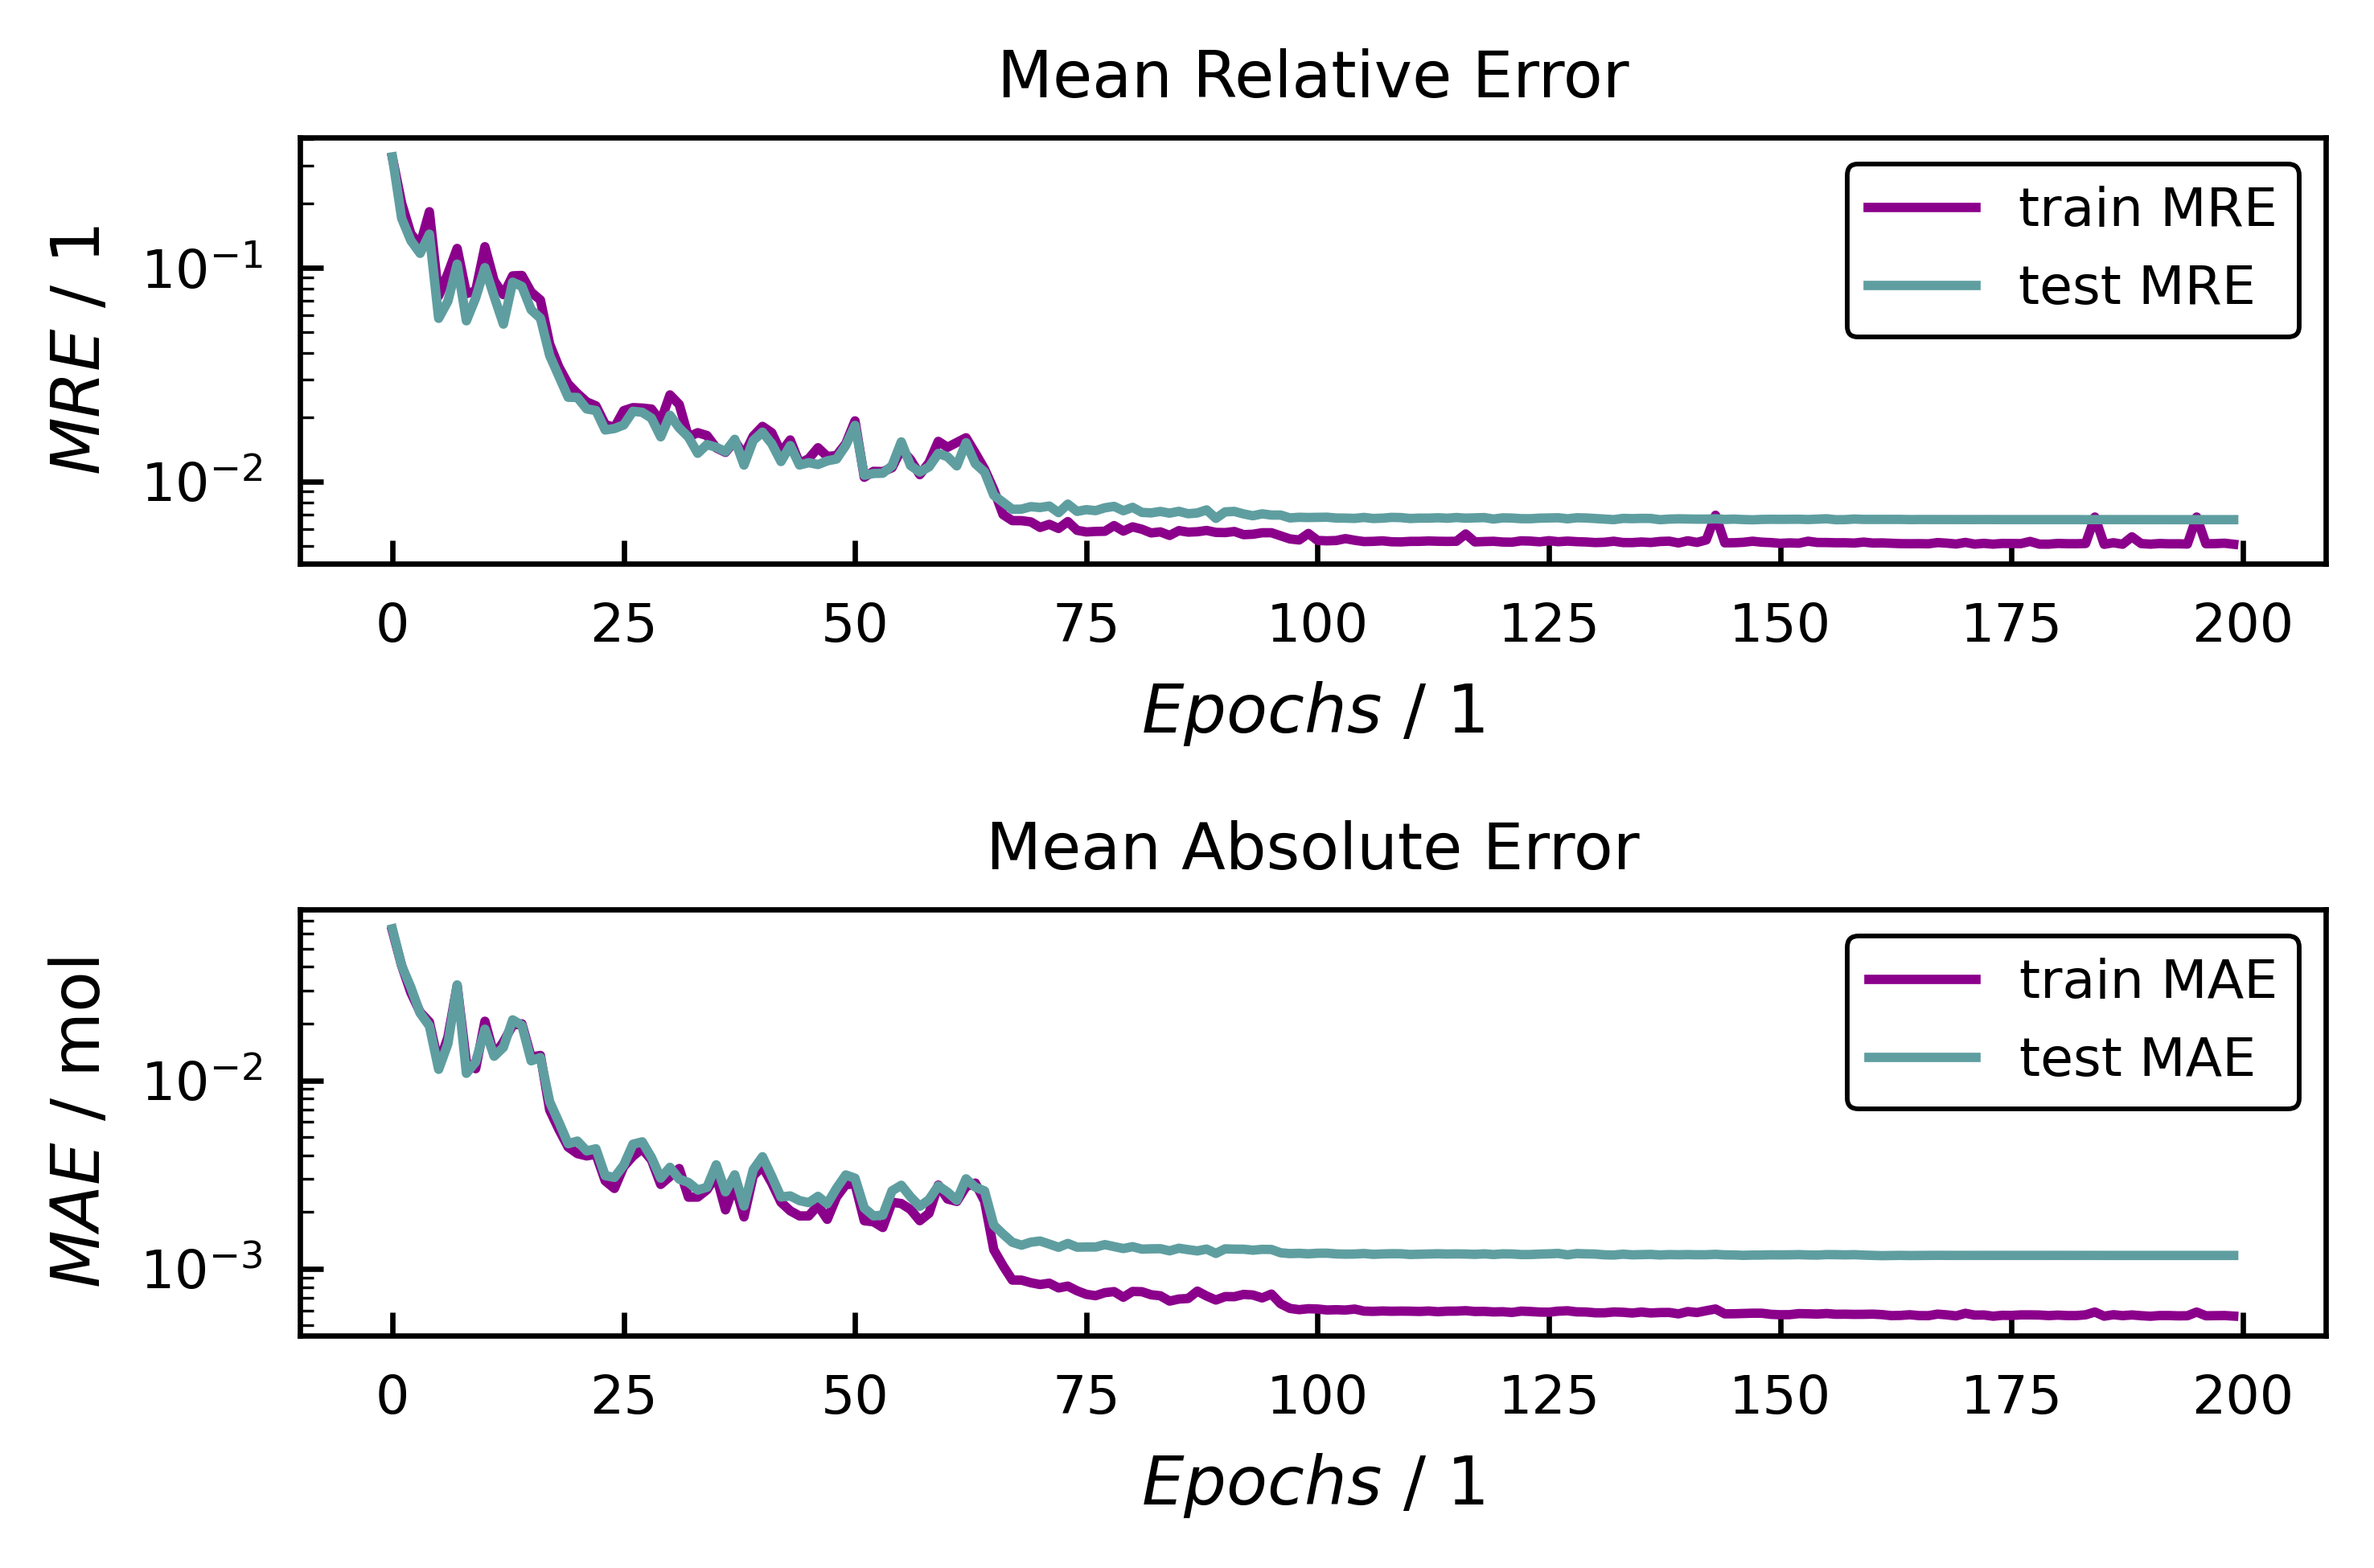

In [18]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

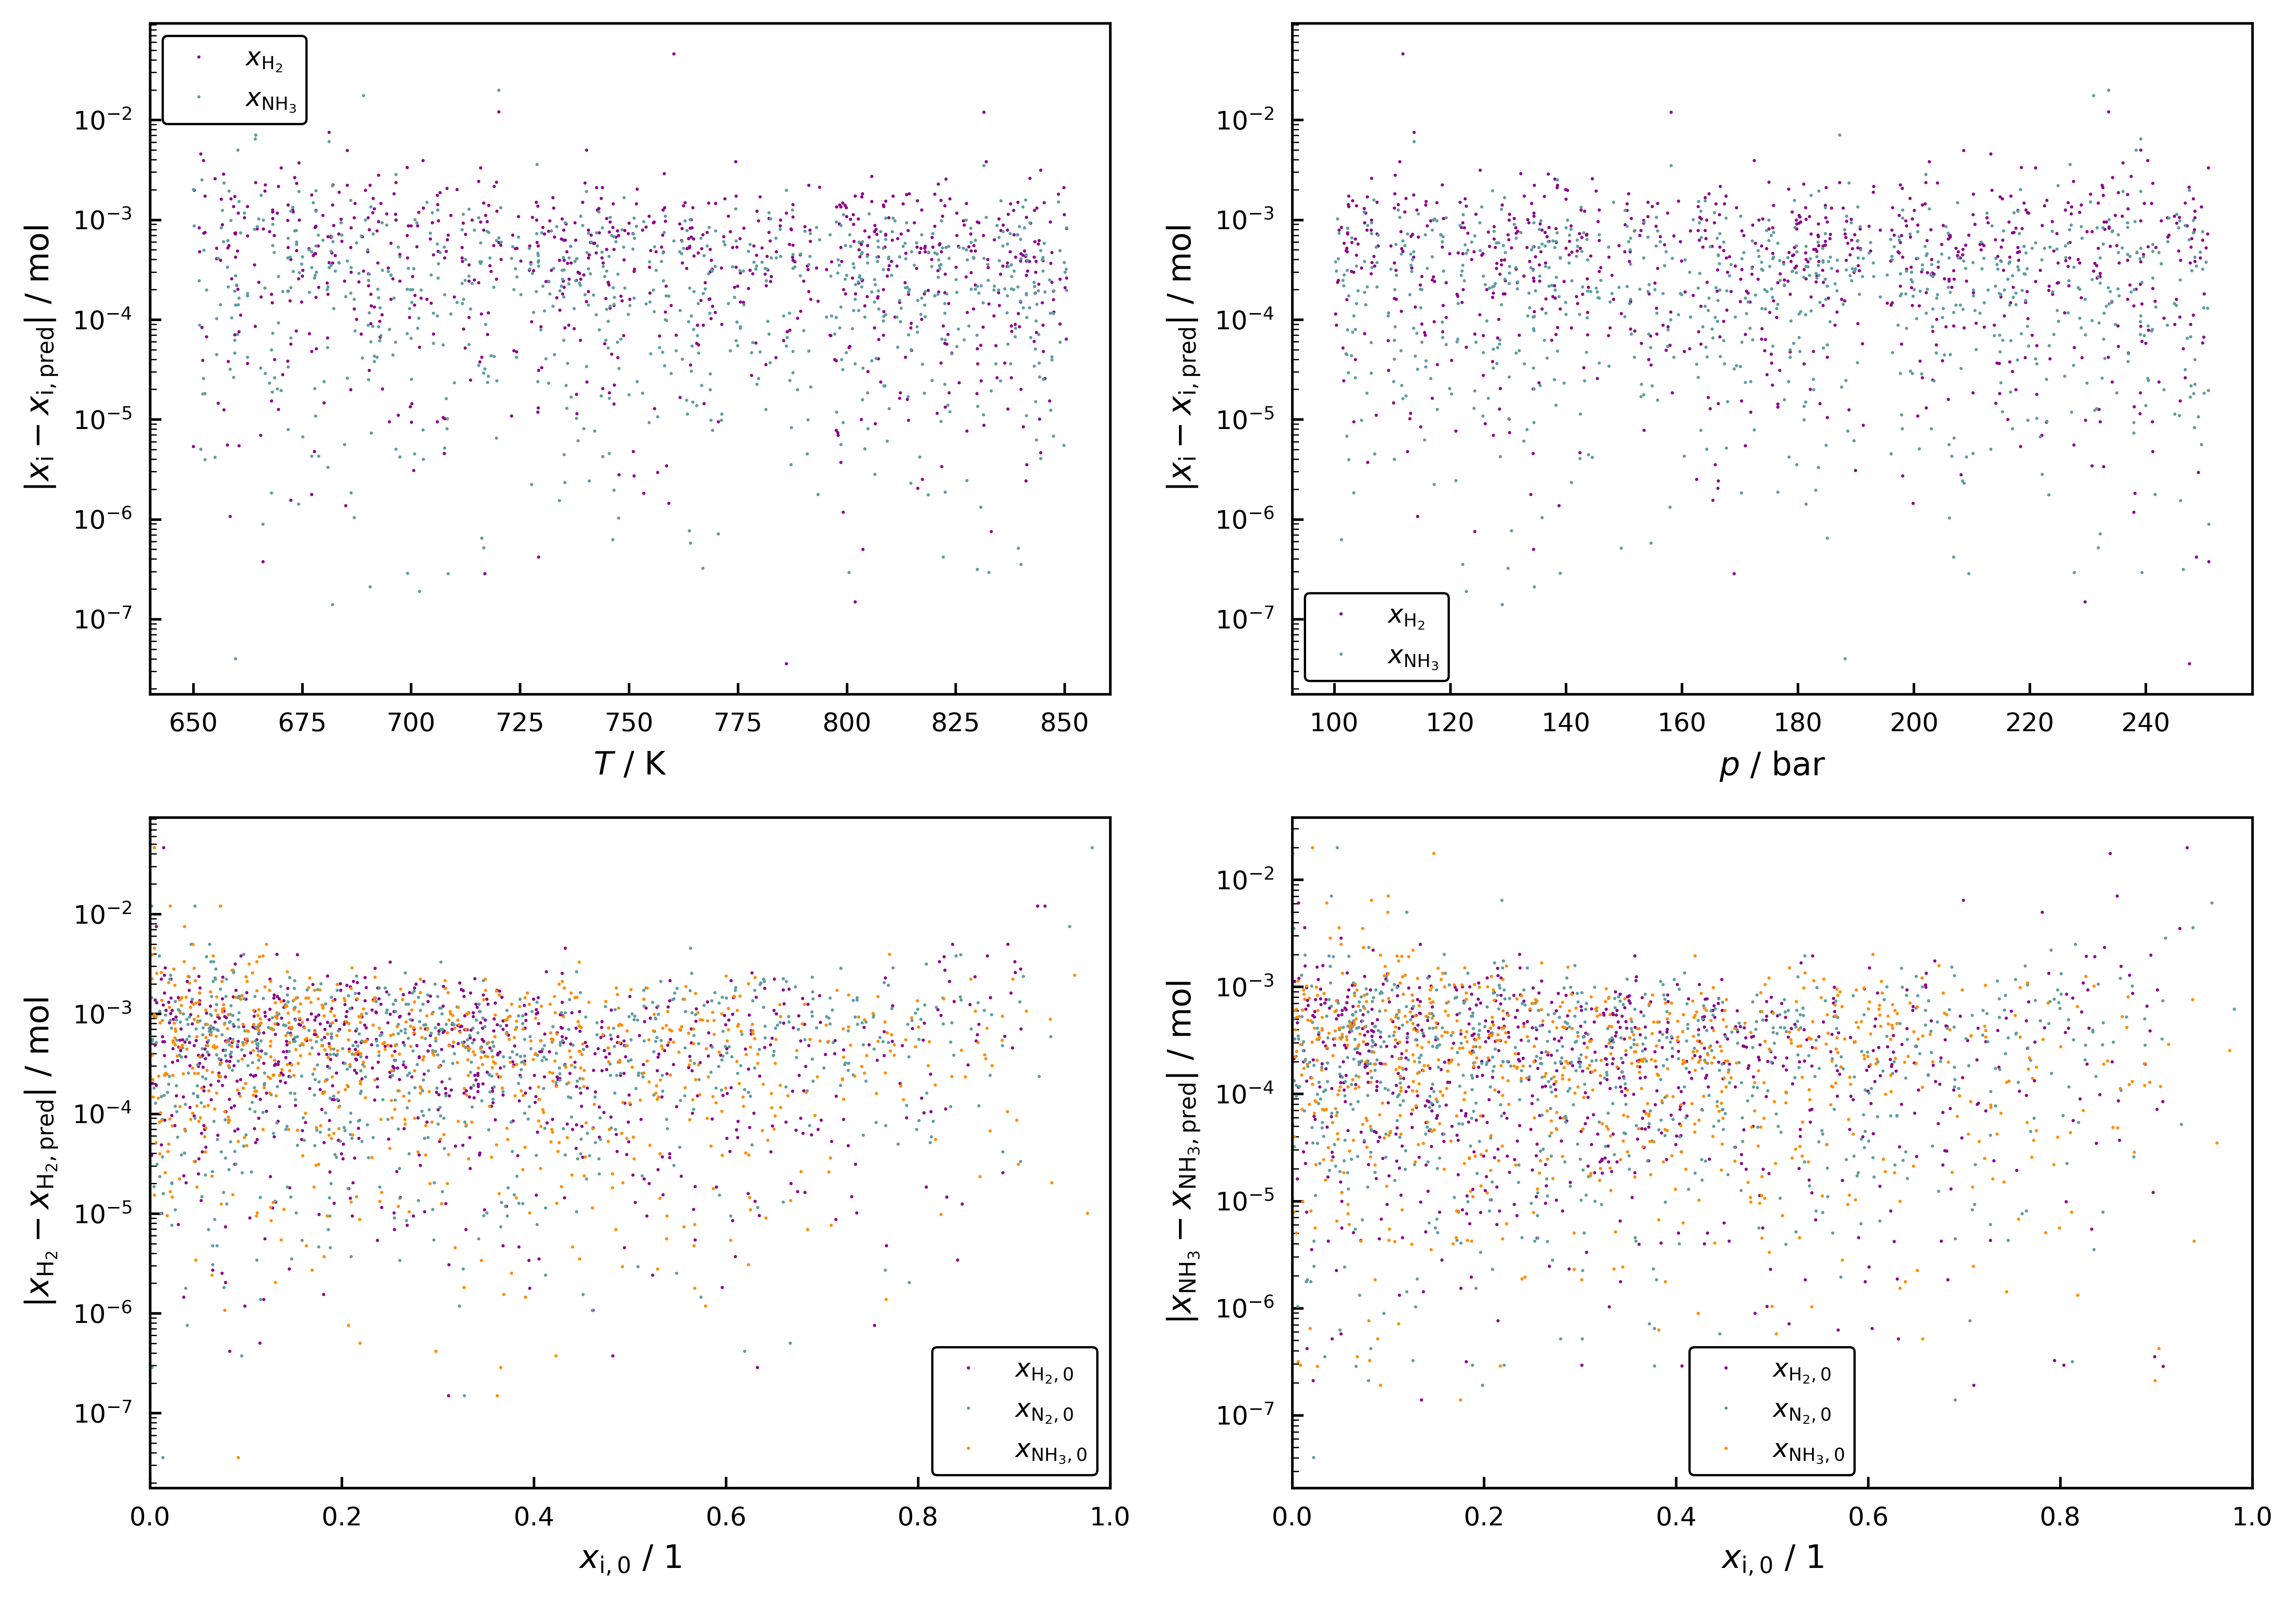

In [19]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

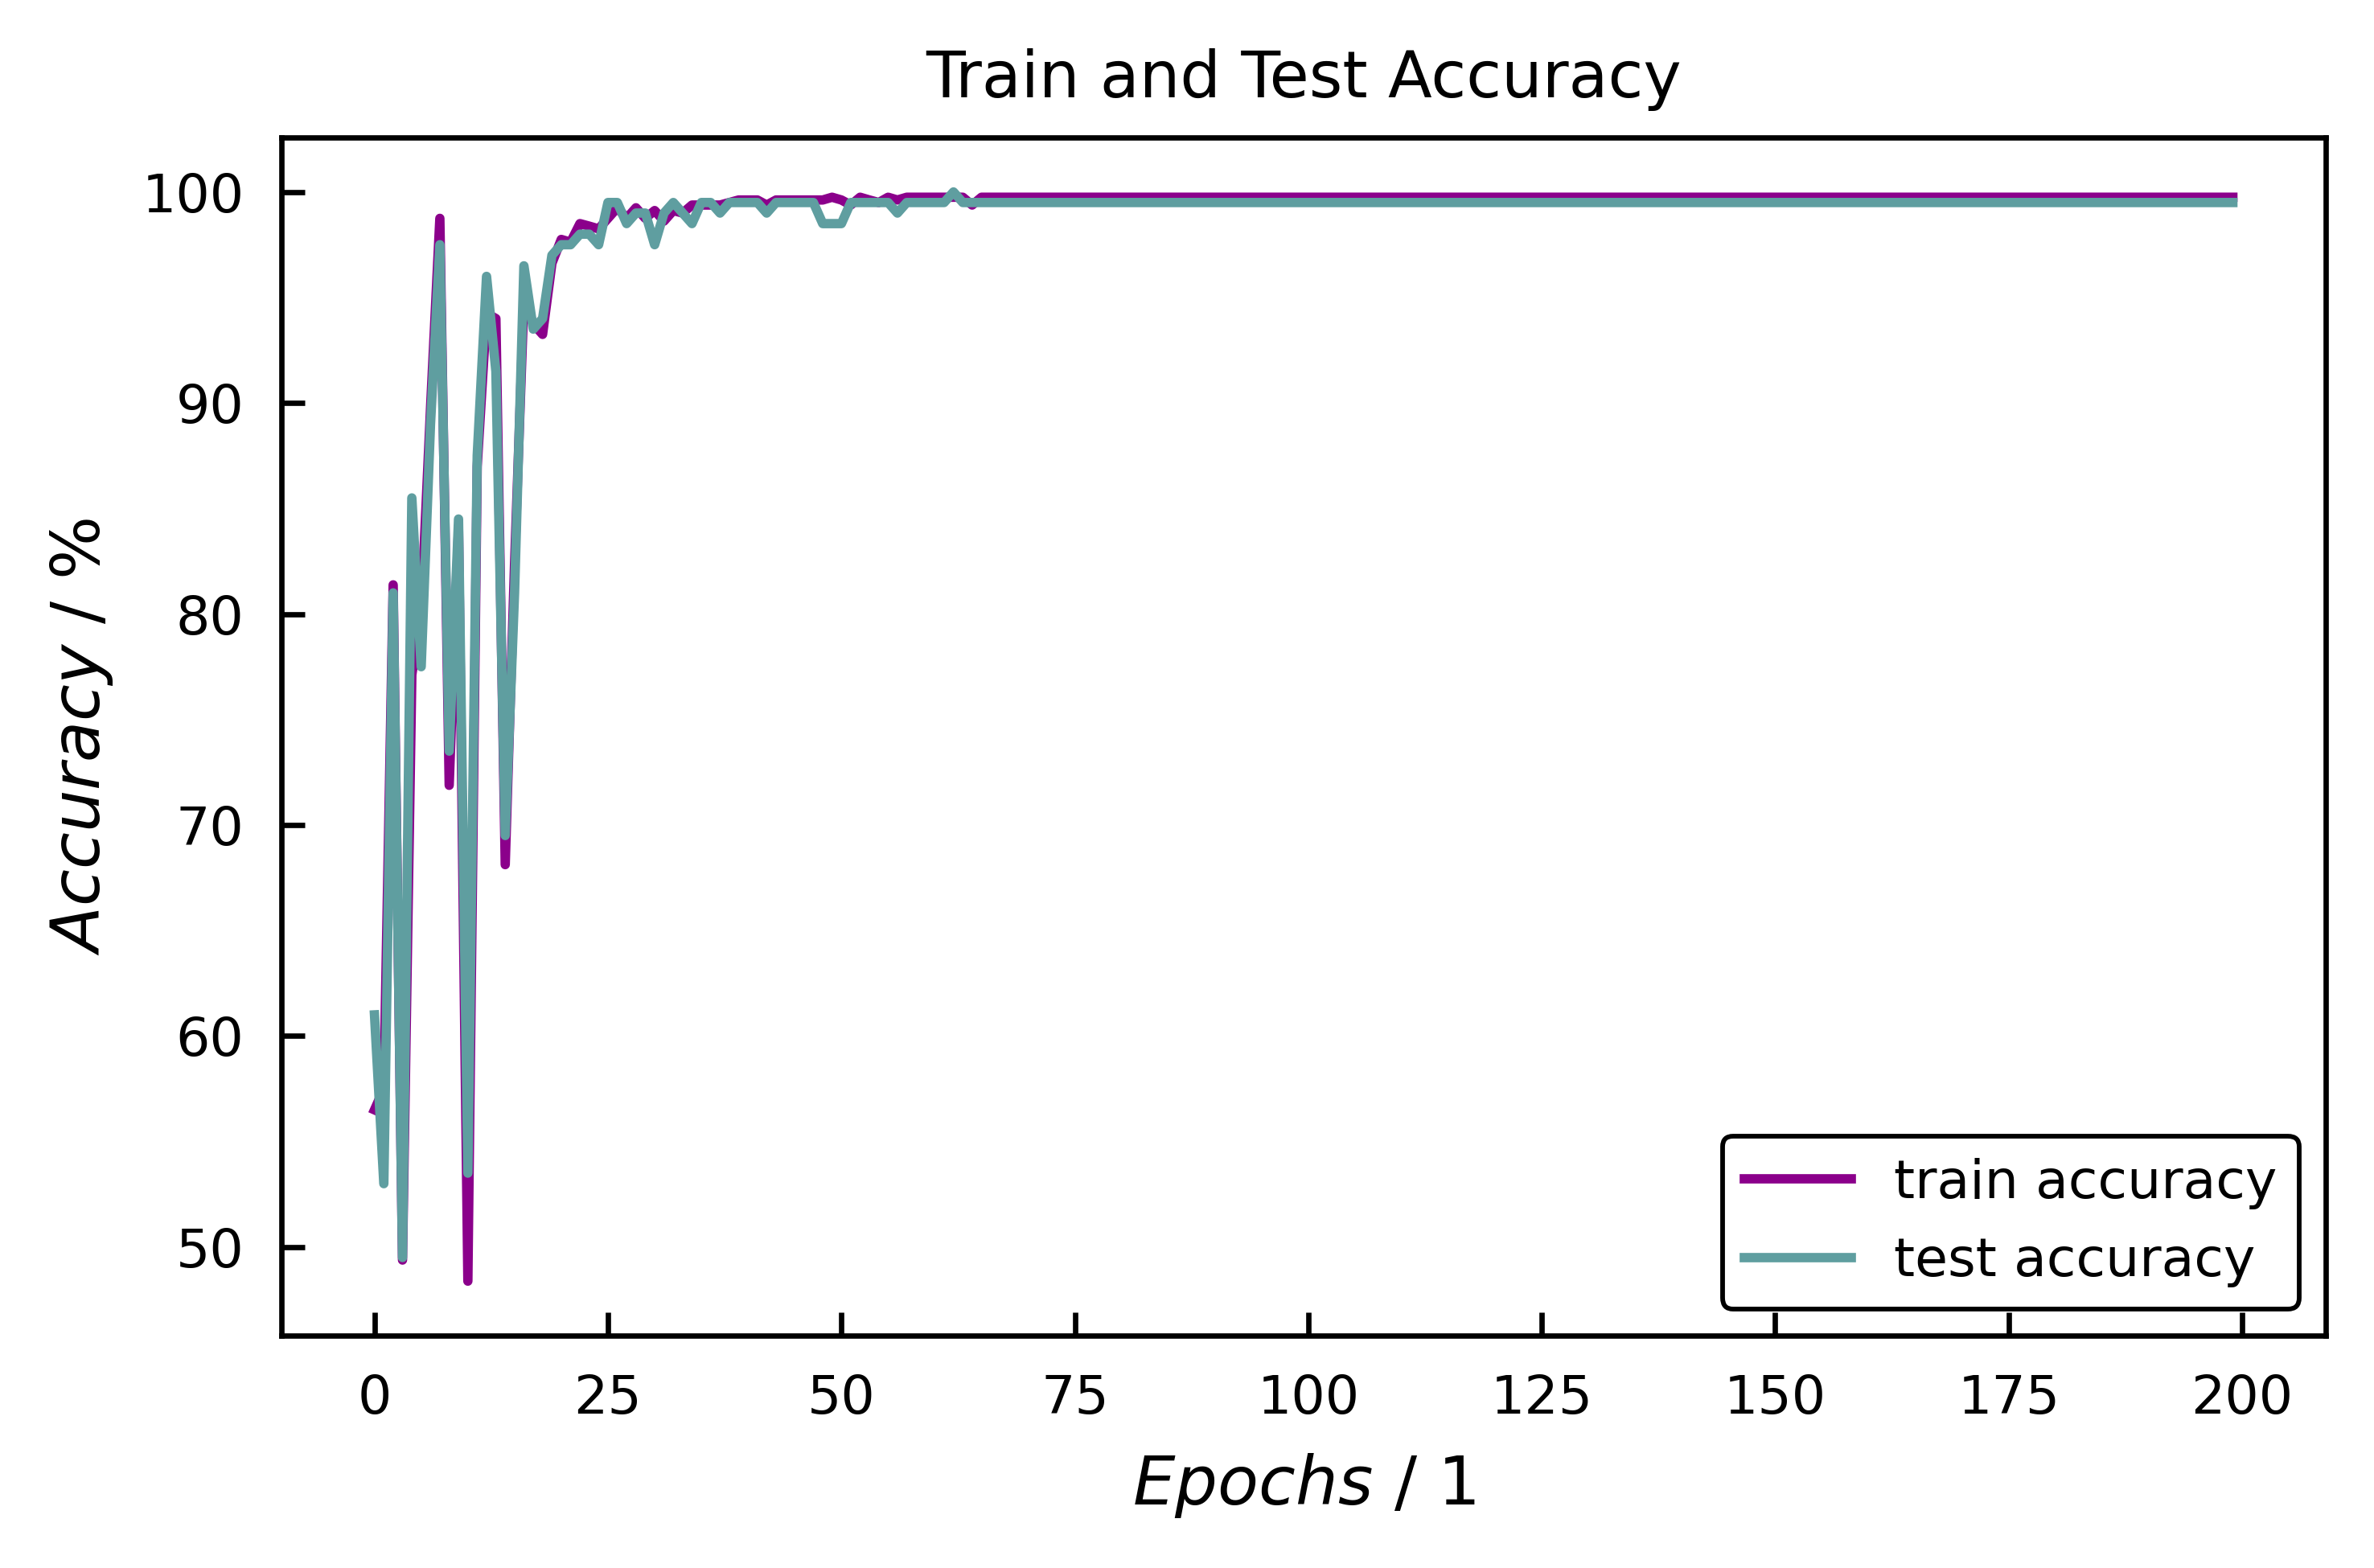

In [20]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [21]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-0.3623,  1.6103, -0.6810, -0.5935,  1.2749],
        [ 0.9230, -0.1178, -1.1215,  0.9641,  0.1153],
        [ 0.3433,  1.6548,  0.3925, -0.2837, -0.0952],
        [-0.2789, -0.1213, -0.6003, -1.2213,  1.8374],
        [-0.6186, -0.6021, -0.4225,  0.2318,  0.1777],
        [-0.6697,  0.9349, -0.9204,  0.7065,  0.1812],
        [ 1.5129, -1.0347, -0.3424,  0.0669,  0.2677],
        [ 0.9407, -0.1802,  1.4081, -0.7077, -0.6585],
        [-1.6306, -0.7251, -1.0438, -0.3139,  1.3452],
        [ 1.2277, -0.9452,  1.1844, -1.3796,  0.2477],
        [ 0.8303, -0.3198,  1.1492, -0.1960, -0.9274],
        [ 0.7585,  0.4759,  1.0682, -0.7902, -0.2407],
        [ 0.2709, -1.6156, -0.8607,  0.2237,  0.6161],
        [-1.4215, -1.3630,  0.2861, -1.2044,  0.9502],
        [ 1.1604, -0.3922,  2.0512, -0.7941, -1.2014],
        [ 0.5427,  0.0982, -1.3514,  2.0746, -0.7942],
        [-0.3251,  0.2492,  0.3715,  0.8444, -1.2277],
        [ 1.0343, -0.2716, -0.8249, -0.7595,  1.5858],
        [-

#### Einblick in Netzwerk

In [22]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-2.7788e-01,  3.4009e-01, -1.1882e-01,  2.8535e-01,  2.7571e-01],
         [ 3.8249e-01,  1.6274e-01,  1.0191e-01,  1.2805e-01,  1.3142e-01],
         [-7.6991e-03,  3.3016e-01,  1.0554e-01,  3.7247e-01,  1.7478e-02],
         [-3.2804e-01,  2.5271e-01,  2.7468e-01, -3.5735e-01, -6.2403e-02],
         [ 3.8717e-01,  2.0299e-01, -2.8040e-01, -1.0232e-01,  9.1706e-02],
         [ 7.0755e-02, -1.8081e-01, -1.1855e-01, -4.0212e-01,  1.6058e-01],
         [-4.0771e-01, -3.7361e-01,  1.2692e-01, -1.6973e-01,  1.1372e-01],
         [-2.7931e-01,  2.5155e-01,  2.0595e-01, -3.8328e-01, -2.5706e-01],
         [ 2.8799e-01, -3.5380e-01, -2.6699e-01,  2.5882e-01, -5.9766e-02],
         [ 1.1415e-01, -3.1755e-01,  2.4552e-01, -3.3728e-01, -2.3901e-01],
         [ 1.9863e-02, -4.0705e-01, -3.0489e-01, -3.6844e-01,  1.6399e-01],
         [-3.1906e-01,  3.9859e-01, -1.6711e-01,  3.2535e-02,  2.6186e-01],
         [ 1.7069e-01, -2.2210e-01,  3.1241e-01, -2.0288e-01, -2.

In [23]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1586, 0.7823, 0.2592, 0.9612, 0.6719],
        [0.3265, 0.9083, 0.1479, 0.7897, 0.9491]])
tensor([[-0.4426,  0.0421],
        [-0.2498,  0.0430]], grad_fn=<AddmmBackward0>)


In [24]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [25]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.6935, -1.3365,  2.0698, -0.6835, -1.3327],
        [-0.4501,  1.1754, -1.3832,  2.5029, -1.2006],
        [ 1.1307,  1.3079,  0.2655, -0.3085,  0.0548],
        [-0.3501, -1.0504,  1.1737, -0.2430, -0.9034],
        [-0.5446,  0.4824, -0.2008, -0.7768,  0.9910],
        [-1.5272,  0.1546,  1.4497, -0.4743, -0.9379],
        [ 1.3896, -1.0719, -0.6107,  0.2069,  0.3879],
        [-0.5285,  1.2862, -1.2825,  0.3490,  0.9019],
        [ 1.3420,  1.0437, -0.7565,  0.5588,  0.1712],
        [ 1.5021,  0.2814, -1.3550,  0.7836,  0.5289],
        [-1.6306, -0.7251, -1.0438, -0.3139,  1.3452],
        [ 0.5683,  1.5450,  0.6013, -0.8992,  0.3290],
        [-0.3251,  0.2492,  0.3715,  0.8444, -1.2277],
        [-0.1473,  0.0035,  0.7826,  0.4982, -1.2772],
        [ 0.8218, -0.5642, -1.2145,  0.7551,  0.4202],
        [-0.8049, -1.4530, -1.4150, -0.2878,  1.6828],
        [ 1.4976, -0.1738, -1.2216, -0.5229,  1.7332],
        [-1.3401,  0.3506, -0.4893,  0.3839,  0.0878],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()